* *DATA CLEANING*
* *DATA IMPUTATION (NaN imputation, Zeros imputation)*
* **NO FEATURE SELECTION**
* **NO GRID SEARCH**

In [ ]:
!pip install lazypredict-nightly

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
!pip install missingno

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [ ]:
import time
import missingno as msno
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
import lazypredict
from lazypredict import LazyRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import (
    LinearRegression, Lars, LassoLarsIC, Lasso, ElasticNet, LassoCV, LarsCV,
    LassoLarsCV, ElasticNetCV, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor,
    Ridge, RidgeCV, SGDRegressor, TweedieRegressor, GammaRegressor, PoissonRegressor
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## Preprocessing and feature engineering of the collected data

In [ ]:
# Load data
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv

--2024-12-30 08:07:23--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338231 (330K) [text/plain]
Saving to: ‘docking_scores_data.csv’

docking_scores_data 100%[===================>] 330.30K  1.83MB/s    in 0.2s    

2024-12-30 08:07:24 (1.83 MB/s) - ‘docking_scores_data.csv’ saved [338231/338231]

--2024-12-30 08:07:24--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [ ]:
df = pd.read_csv("docking_scores_data.csv")
df.columns

Index(['smiles', 'Delta_Gibbs'], dtype='object')

In [ ]:
# Handling missing data && cleaning
df = df.dropna(subset=['Delta_Gibbs'])
df = df.drop_duplicates(['smiles']).reset_index(drop=True)
df.shape

(8515, 2)

In [ ]:
# Load RDKit descriptors
RDKit_df = pd.read_csv("RDKit_descriptors.csv")
RDKit_df.shape

(8515, 210)

In [ ]:
# Load PaDEL descriptors
PaDEL_df = pd.read_csv("PaDEL_descriptors.csv")
PaDEL_df.shape

(8515, 1444)

### Exploratory Data Analysis (EDA)

**Frequency plot of Delta Gibbs**

Text(0, 0.5, 'Frequency')

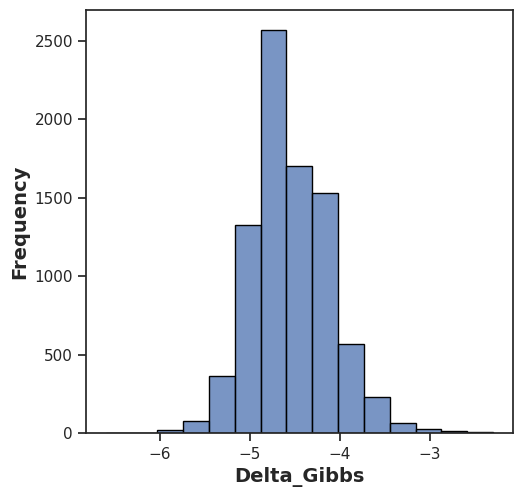

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.histplot(x='Delta_Gibbs', data=df, bins=15, edgecolor='black')

plt.xlabel('Delta_Gibbs', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# plt.savefig('plot_bioactivity_class.pdf')

**Delta Gibbs Box plot**


Text(0, 0.5, 'Delta_Gibbs')

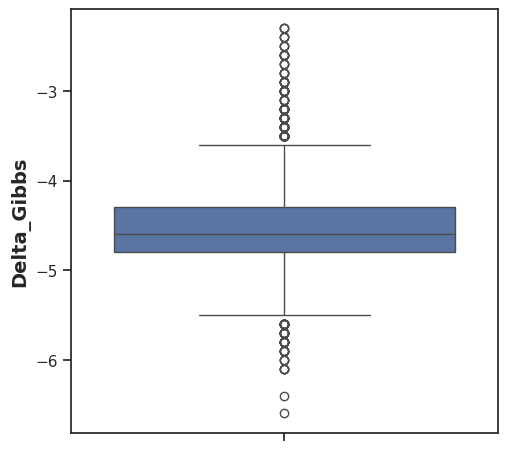

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(y='Delta_Gibbs', data=df)

plt.ylabel('Delta_Gibbs', fontsize=14, fontweight='bold')

**Descriptors Box Plot**

<Axes: >

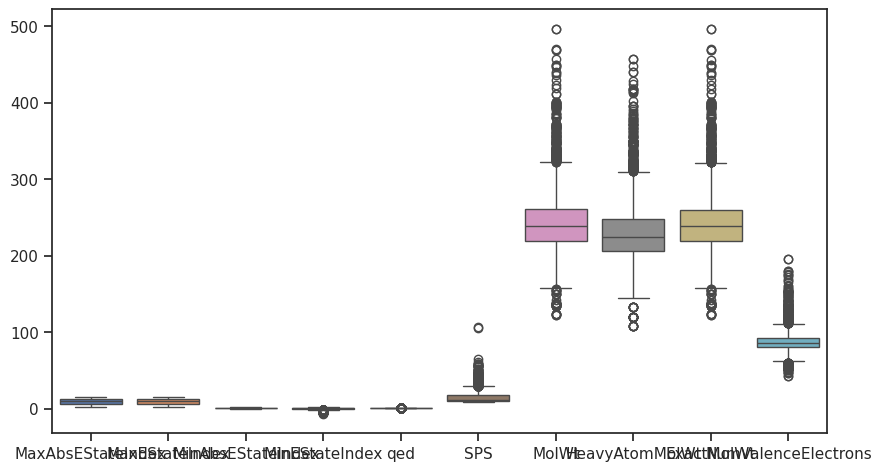

In [ ]:
# RDKit
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=RDKit_df.iloc[:,:10])

<Axes: >

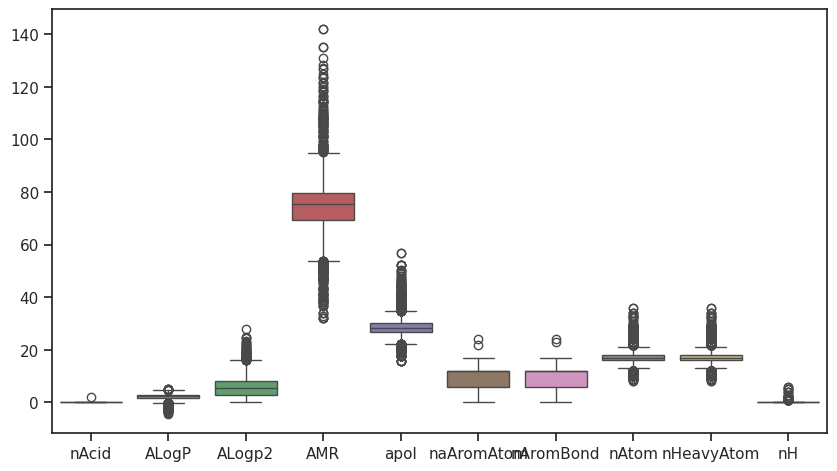

In [ ]:
# PaDEL
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=PaDEL_df.iloc[:,:10])

**NaN Visualization**

<Axes: >

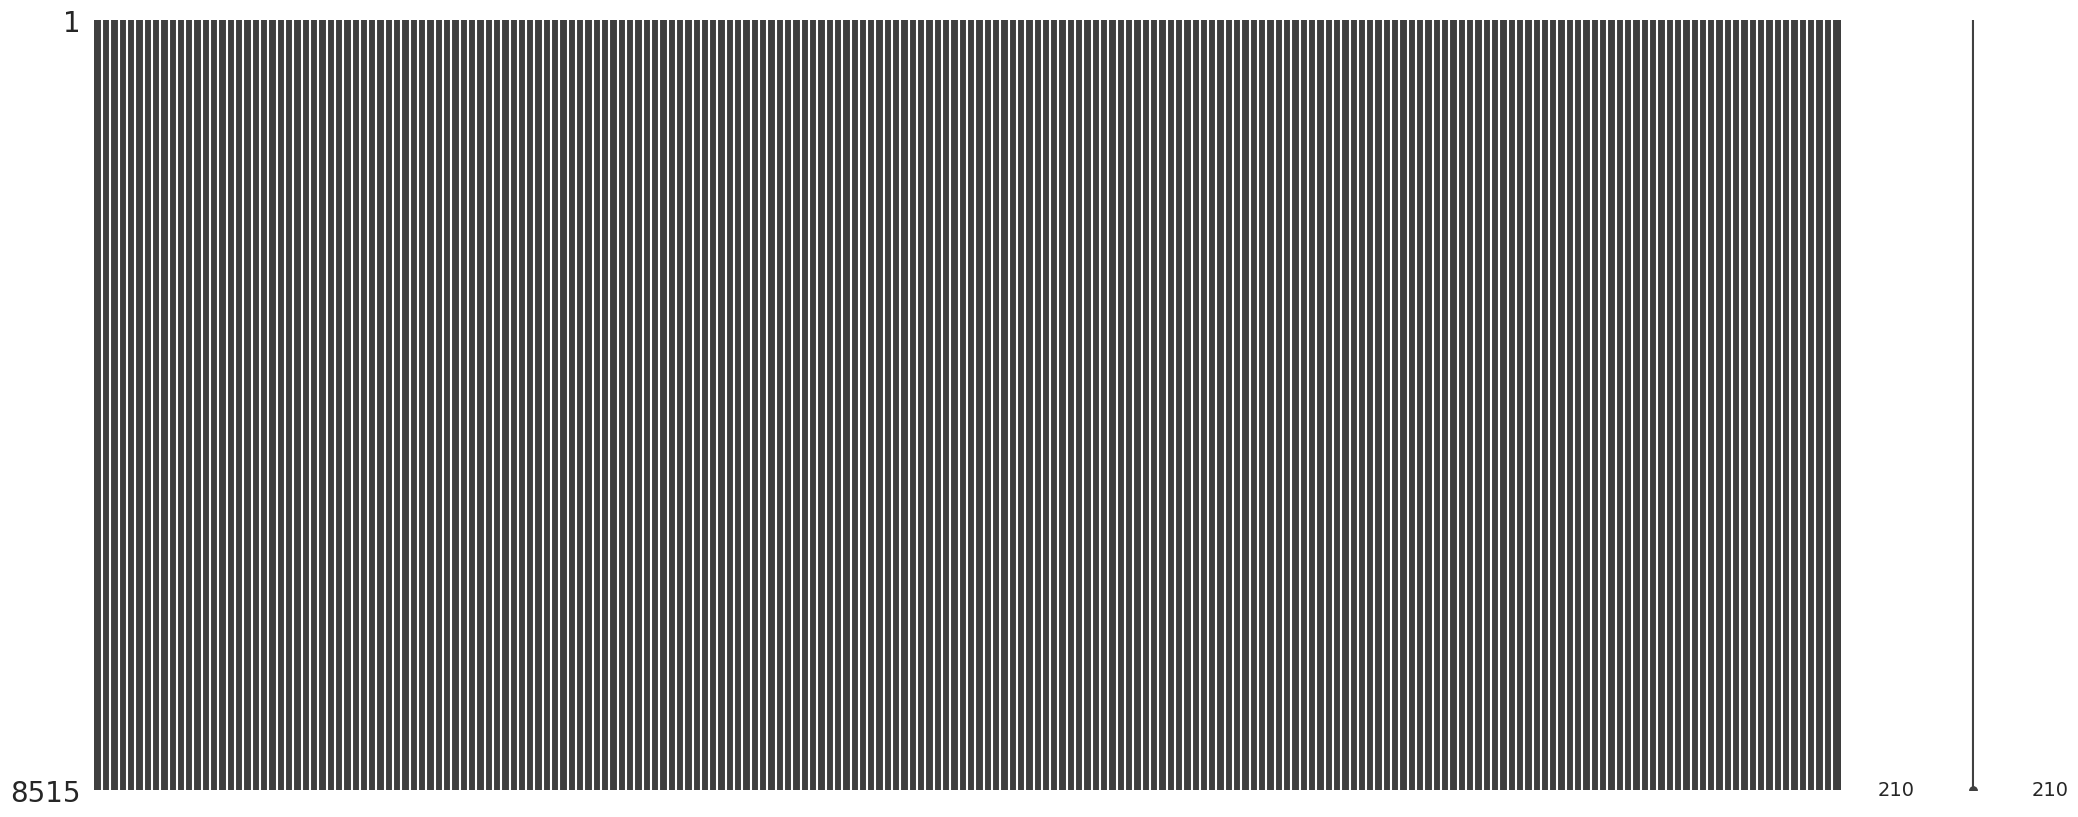

In [ ]:
# RDKit
msno.matrix(RDKit_df)

<Axes: >

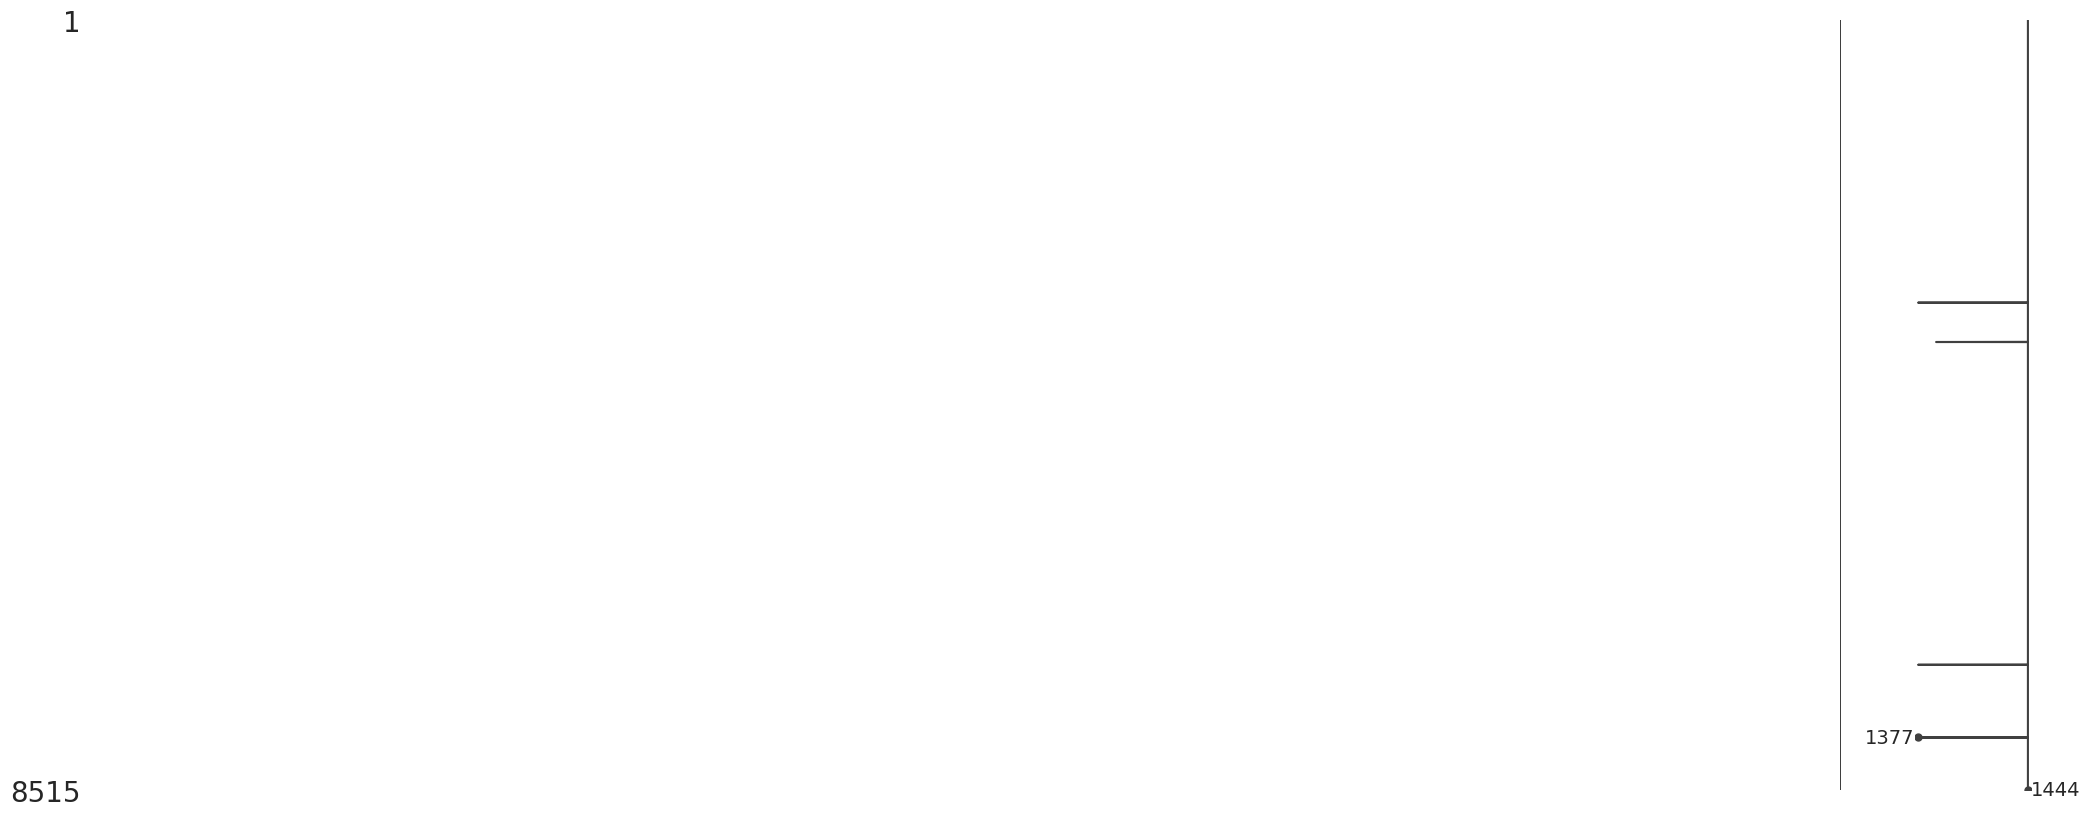

In [ ]:
# PaDEL
msno.matrix(PaDEL_df)

### Data Cleaning

RDKit

In [ ]:
RDKit_df.shape

(8515, 210)

In [ ]:
# Drop columns with 90% NaN
RDKit_df = RDKit_df.loc[:, RDKit_df.isna().mean(axis=0) < 0.9]
RDKit_df.shape

(8515, 210)

In [ ]:
# fill NaN values with the median of each column
RDKit_df.fillna(RDKit_df.median(), inplace=True)
RDKit_df.shape

(8515, 210)

In [ ]:
# Drop columns with 90% zeros
RDKit_df = RDKit_df.loc[:, (RDKit_df == 0).mean(axis=0) < 0.9]
RDKit_df.shape

(8515, 129)

PaDEL

In [ ]:
PaDEL_df.shape

(8515, 1444)

In [ ]:
# Drop columns with 90% NaN
PaDEL_df = PaDEL_df.loc[:, PaDEL_df.isna().mean(axis=0) < 0.9]
PaDEL_df.shape

(8515, 1444)

In [ ]:
# fill NaN values with the median of each column
PaDEL_df.fillna(PaDEL_df.median(), inplace=True)
PaDEL_df.shape

(8515, 1444)

In [ ]:
# Drop columns with 90% zeros
PaDEL_df = PaDEL_df.loc[:, (PaDEL_df == 0).mean(axis=0) < 0.9]
PaDEL_df.shape

(8515, 928)

### Data Transformation

In [ ]:
# Initialization of data scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [ ]:
# Scale data
RDKit_scaled = robust_scaler.fit_transform(RDKit_df)
RDKit_scaled = minmax_scaler.fit_transform(RDKit_scaled)
PaDEL_scaled = robust_scaler.fit_transform(PaDEL_df)
PaDEL_scaled = minmax_scaler.fit_transform(PaDEL_scaled)

In [ ]:
# Create RDKit scaled DataFrame
RDKit_columns = RDKit_df.columns
RDKit_scaled_df = pd.DataFrame(RDKit_scaled)
RDKit_scaled_df.columns = RDKit_columns
RDKit_scaled_df.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_NH0,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_para_hydroxylation,fr_sulfide
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.50,0.50,0.32,0.81,0.66,0.07,0.32,0.35,0.32,0.28,...,0.07,0.03,0.09,0.51,0.04,0.02,0.07,0.09,0.06,0.03
std,0.28,0.28,0.24,0.15,0.13,0.07,0.09,0.10,0.09,0.08,...,0.12,0.08,0.15,0.20,0.09,0.07,0.12,0.13,0.14,0.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.27,0.12,0.77,0.57,0.02,0.26,0.28,0.26,0.25,...,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.63,0.63,0.25,0.83,0.68,0.03,0.31,0.33,0.31,0.29,...,0.00,0.00,0.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.76,0.76,0.49,0.91,0.75,0.10,0.37,0.40,0.37,0.32,...,0.20,0.00,0.20,0.67,0.00,0.00,0.20,0.11,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# Create PaDEL scaled DataFrame
PaDEL_columns = PaDEL_df.columns
PaDEL_scaled_df = pd.DataFrame(PaDEL_scaled)
PaDEL_scaled_df.columns = PaDEL_columns
PaDEL_scaled_df.describe()

,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nC,nN,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.67,0.20,0.38,0.31,0.42,0.42,0.31,0.31,0.45,0.06,...,0.20,0.32,0.31,0.27,0.09,0.06,0.12,0.26,0.45,0.28
std,0.11,0.13,0.08,0.08,0.14,0.14,0.08,0.08,0.08,0.09,...,0.08,0.08,0.07,0.17,0.10,0.10,0.06,0.09,0.10,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.61,0.10,0.34,0.27,0.25,0.25,0.29,0.29,0.40,0.00,...,0.15,0.29,0.27,0.12,0.00,0.00,0.09,0.21,0.39,0.22
50%,0.69,0.19,0.39,0.31,0.50,0.50,0.32,0.32,0.44,0.00,...,0.19,0.33,0.30,0.23,0.09,0.00,0.11,0.26,0.44,0.26
75%,0.74,0.29,0.43,0.35,0.50,0.50,0.36,0.36,0.48,0.14,...,0.23,0.37,0.34,0.36,0.12,0.14,0.14,0.31,0.51,0.32
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Merge descriptors dataframes with Delta Gibbs scores

In [ ]:
RDKit = pd.concat([RDKit_scaled_df,df['Delta_Gibbs']], axis = 1)
RDKit

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_para_hydroxylation,fr_sulfide,Delta_Gibbs
0,0.77,0.77,0.28,0.40,0.82,0.07,0.41,0.44,0.41,0.38,...,0.00,0.00,0.67,0.12,0.00,0.00,0.00,0.00,0.00,-4.20
1,0.72,0.72,0.21,0.40,0.76,0.03,0.32,0.35,0.32,0.23,...,0.00,0.00,0.67,0.12,0.00,0.00,0.11,0.00,0.00,-4.20
2,0.76,0.76,0.24,0.39,0.89,0.03,0.42,0.44,0.42,0.39,...,0.00,0.00,0.67,0.12,0.00,0.00,0.00,0.00,0.00,-4.20
3,0.67,0.67,0.03,0.76,0.61,0.02,0.29,0.32,0.29,0.29,...,0.00,0.00,0.67,0.12,0.00,0.00,0.00,0.00,0.00,-4.50
4,0.76,0.76,0.13,0.37,0.95,0.06,0.41,0.45,0.41,0.36,...,0.00,0.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.59,0.01,0.82,0.96,0.04,0.48,0.51,0.48,0.47,...,0.00,0.00,0.67,0.12,0.00,0.60,0.00,0.00,0.00,-4.90
8511,0.57,0.57,0.11,0.84,0.88,0.02,0.44,0.46,0.44,0.44,...,0.00,0.00,0.67,0.00,0.00,0.60,0.00,0.33,0.00,-4.70
8512,0.63,0.63,0.01,0.82,0.76,0.03,0.48,0.51,0.48,0.47,...,0.00,0.00,0.67,0.25,0.00,0.60,0.00,0.00,0.00,-4.70
8513,0.62,0.62,0.03,0.82,0.70,0.04,0.40,0.43,0.40,0.39,...,0.00,0.00,0.67,0.25,0.00,0.40,0.00,0.00,0.00,-5.10


In [ ]:
PaDEL = pd.concat([PaDEL_scaled_df,df['Delta_Gibbs']], axis = 1)
PaDEL

,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nC,nN,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Delta_Gibbs
0,0.48,0.00,0.46,0.38,0.42,0.46,0.39,0.39,0.44,0.29,...,0.40,0.27,0.54,0.18,0.29,0.14,0.45,0.22,0.42,-4.20
1,0.61,0.09,0.32,0.25,0.42,0.46,0.25,0.25,0.32,0.00,...,0.26,0.27,0.40,0.18,0.00,0.07,0.29,0.34,0.24,-4.20
2,0.50,0.01,0.48,0.38,0.42,0.46,0.39,0.39,0.44,0.29,...,0.40,0.20,0.53,0.18,0.29,0.14,0.45,0.24,0.38,-4.20
3,0.56,0.04,0.29,0.24,0.42,0.46,0.32,0.32,0.36,0.29,...,0.33,0.26,0.49,0.27,0.29,0.11,0.32,0.30,0.29,-4.50
4,0.39,0.01,0.40,0.35,0.42,0.46,0.39,0.39,0.40,0.29,...,0.41,0.34,0.63,0.28,0.29,0.13,0.48,0.14,0.43,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.44,0.00,0.53,0.44,0.50,0.50,0.50,0.50,0.56,0.00,...,0.53,0.36,0.51,0.51,0.00,0.24,0.50,0.35,0.49,-4.90
8511,0.53,0.02,0.54,0.42,0.50,0.50,0.46,0.46,0.56,0.00,...,0.48,0.26,0.41,0.41,0.00,0.23,0.40,0.41,0.39,-4.70
8512,0.46,0.00,0.53,0.44,0.50,0.50,0.50,0.50,0.56,0.00,...,0.53,0.34,0.52,0.52,0.00,0.21,0.63,0.38,0.50,-4.70
8513,0.51,0.02,0.47,0.38,0.50,0.50,0.43,0.43,0.52,0.00,...,0.45,0.37,0.41,0.41,0.00,0.16,0.53,0.36,0.43,-5.10


In [ ]:
RDKit_PaDEL = pd.concat([RDKit_scaled_df,PaDEL_scaled_df,df['Delta_Gibbs']], axis = 1)
RDKit_PaDEL

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb,Delta_Gibbs
0,0.77,0.77,0.28,0.40,0.82,0.07,0.41,0.44,0.41,0.38,...,0.40,0.27,0.54,0.18,0.29,0.14,0.45,0.22,0.42,-4.20
1,0.72,0.72,0.21,0.40,0.76,0.03,0.32,0.35,0.32,0.23,...,0.26,0.27,0.40,0.18,0.00,0.07,0.29,0.34,0.24,-4.20
2,0.76,0.76,0.24,0.39,0.89,0.03,0.42,0.44,0.42,0.39,...,0.40,0.20,0.53,0.18,0.29,0.14,0.45,0.24,0.38,-4.20
3,0.67,0.67,0.03,0.76,0.61,0.02,0.29,0.32,0.29,0.29,...,0.33,0.26,0.49,0.27,0.29,0.11,0.32,0.30,0.29,-4.50
4,0.76,0.76,0.13,0.37,0.95,0.06,0.41,0.45,0.41,0.36,...,0.41,0.34,0.63,0.28,0.29,0.13,0.48,0.14,0.43,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.59,0.01,0.82,0.96,0.04,0.48,0.51,0.48,0.47,...,0.53,0.36,0.51,0.51,0.00,0.24,0.50,0.35,0.49,-4.90
8511,0.57,0.57,0.11,0.84,0.88,0.02,0.44,0.46,0.44,0.44,...,0.48,0.26,0.41,0.41,0.00,0.23,0.40,0.41,0.39,-4.70
8512,0.63,0.63,0.01,0.82,0.76,0.03,0.48,0.51,0.48,0.47,...,0.53,0.34,0.52,0.52,0.00,0.21,0.63,0.38,0.50,-4.70
8513,0.62,0.62,0.03,0.82,0.70,0.04,0.40,0.43,0.40,0.39,...,0.45,0.37,0.41,0.41,0.00,0.16,0.53,0.36,0.43,-5.10


### Prepare the output/input dataframes

*   **Input:** RDKit or PaDEL or RDKit & PaDEL descriptors
*   **Output:** Delta Gibbs value

In [ ]:
# RDKit
input_1 = RDKit.iloc[:,:-1]
output_1 = RDKit.iloc[:,-1]

# PaDEL
input_2 = PaDEL.iloc[:,:-1]
output_2 = PaDEL.iloc[:,-1]

# RDKit & PaDEL
input_3 = RDKit_PaDEL.iloc[:,:-1]
output_3 = RDKit_PaDEL.iloc[:,-1]

In [ ]:
# Split the data to training and testing
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(input_1, output_1, test_size=0.30, random_state=3) # RDKit
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(input_2, output_2, test_size=0.30, random_state=3) # PaDEL
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(input_3, output_3, test_size=0.30, random_state=3) # RDKit & PaDEL

## Apply Machine Learning Algorithms

### Apply Lazy Regressor

RDKit

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_1, predictions_1 = clf.fit(X_train_1, X_test_1, Y_train_1, Y_test_1)

 98%|█████████▊| 41/42 [02:22<00:02,  2.72s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21083
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 129
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [02:23<00:00,  3.43s/it]


[(0.0, 1.0)]

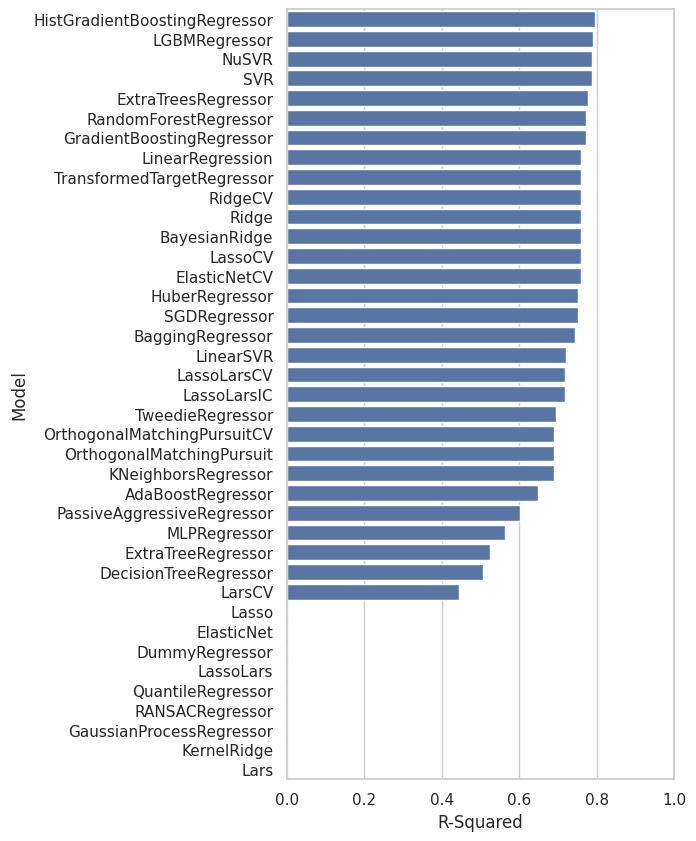

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_1.index, x="R-Squared", data=predictions_1)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

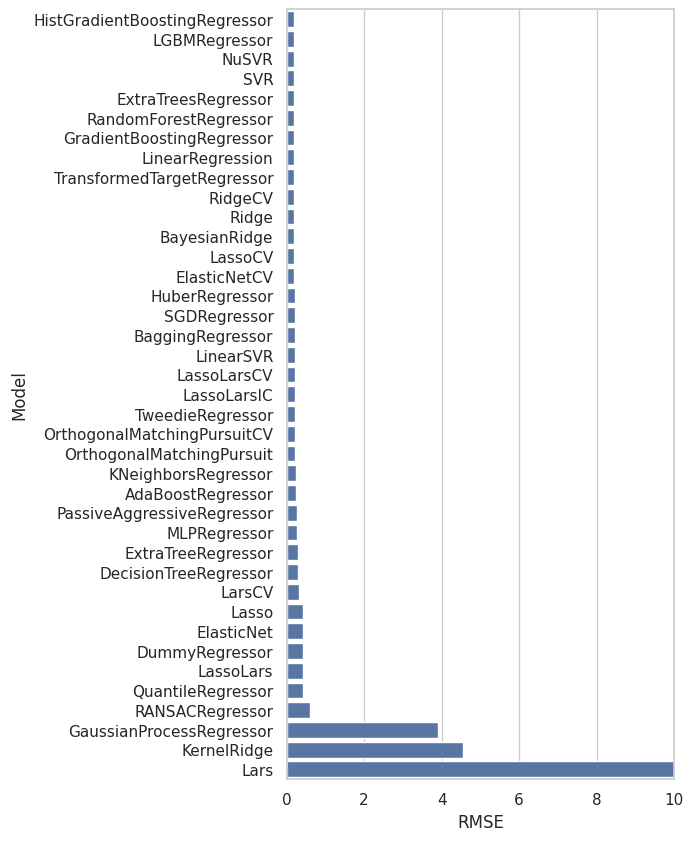

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_1.index, x="RMSE", data=predictions_1)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

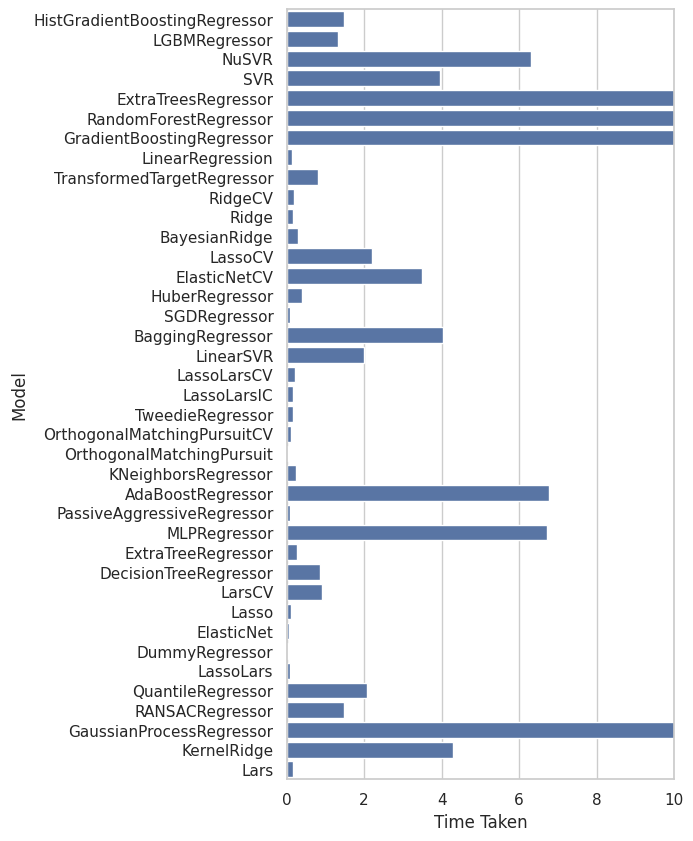

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_1.index, x="Time Taken", data=predictions_1)
ax.set(xlim=(0, 10))

PaDEL

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_2, predictions_2 = clf.fit(X_train_2, X_test_2, Y_train_2, Y_test_2)

 98%|█████████▊| 41/42 [20:08<00:21, 21.98s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208210
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 927
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [20:23<00:00, 29.13s/it]


[(0.0, 1.0)]

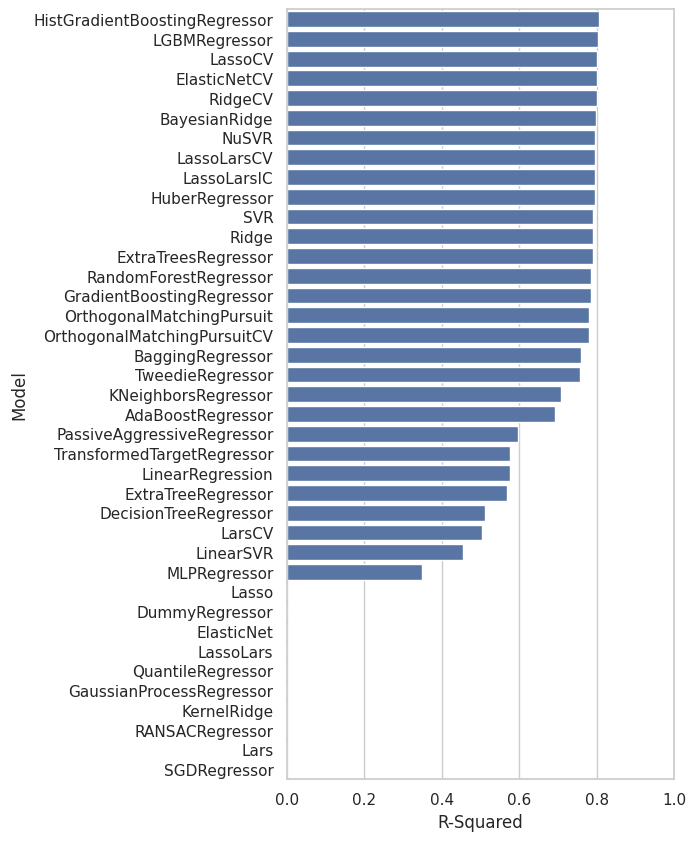

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_2.index, x="R-Squared", data=predictions_2)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

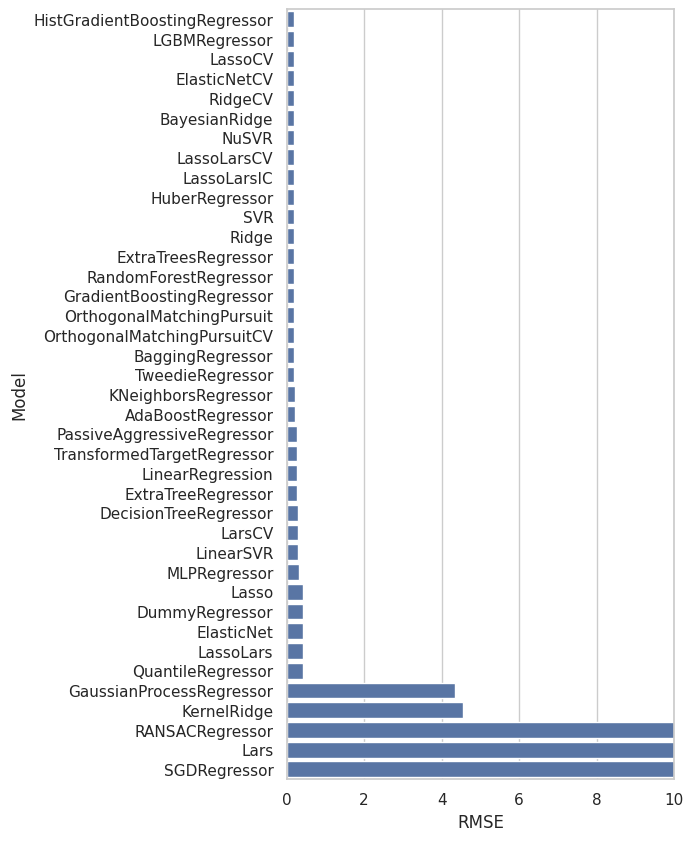

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_2.index, x="RMSE", data=predictions_2)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

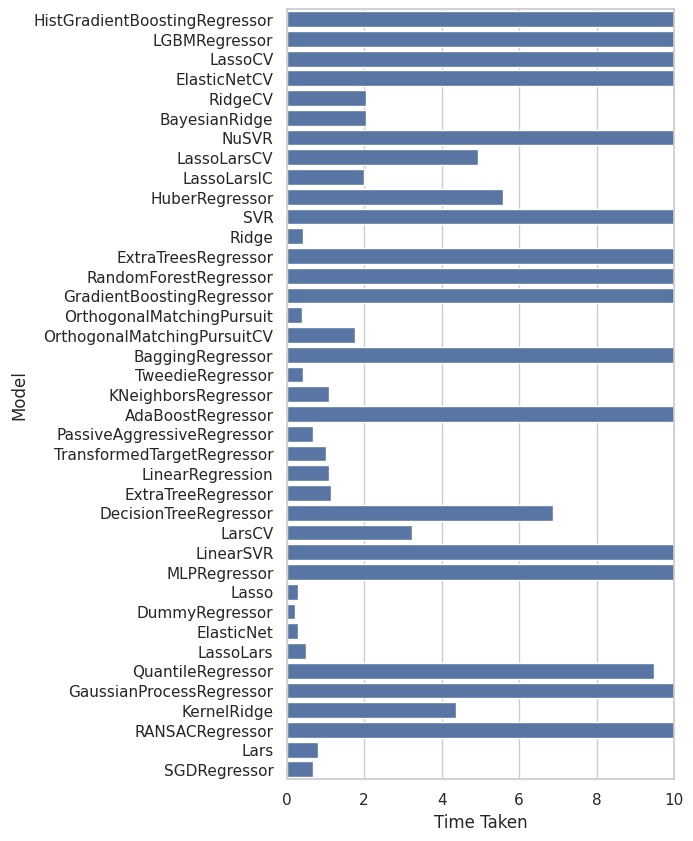

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_2.index, x="Time Taken", data=predictions_2)
ax.set(xlim=(0, 10))

RDKit & PADEL

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_3, predictions_3 = clf.fit(X_train_3, X_test_3, Y_train_3, Y_test_3)

 98%|█████████▊| 41/42 [23:17<00:25, 25.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229293
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 1056
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [23:33<00:00, 33.65s/it]


[(0.0, 1.0)]

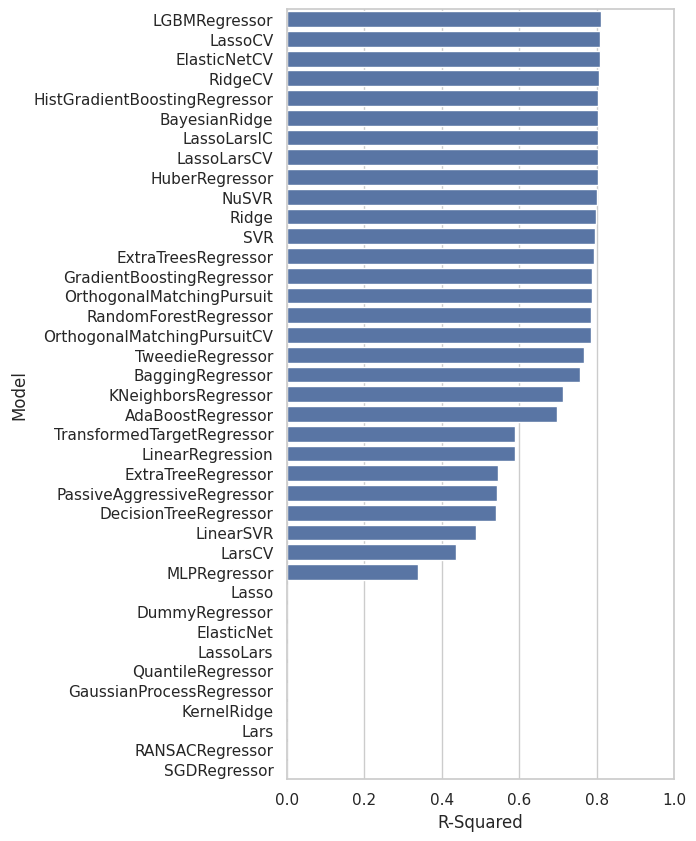

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_3.index, x="R-Squared", data=predictions_3)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

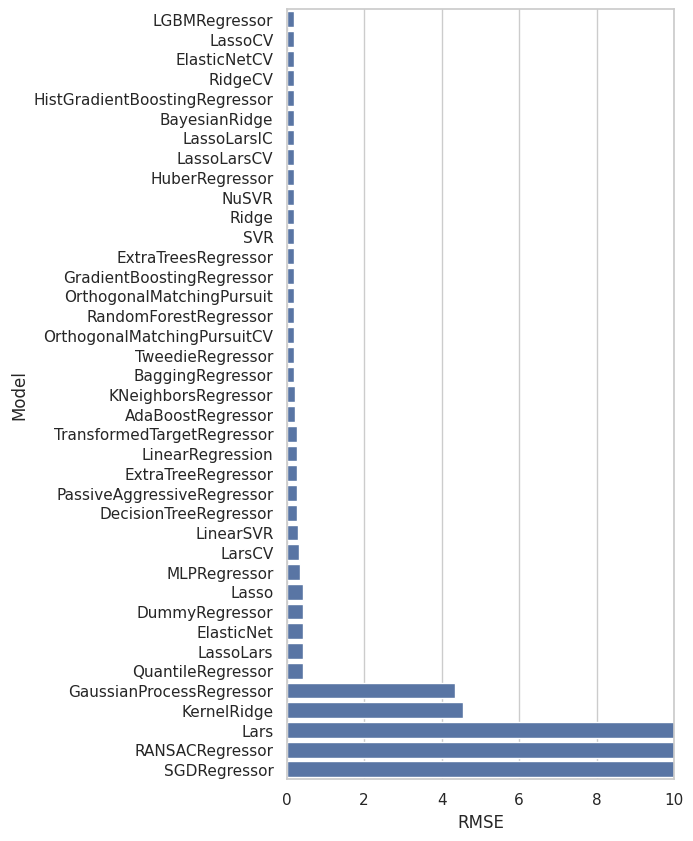

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_3.index, x="RMSE", data=predictions_3)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

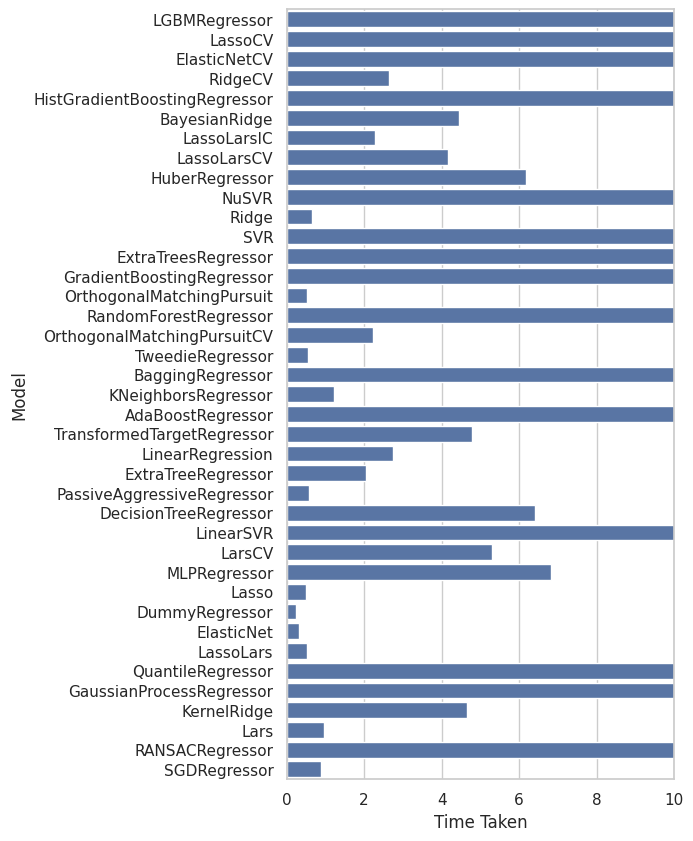

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_3.index, x="Time Taken", data=predictions_3)
ax.set(xlim=(0, 10))

### Apply Regressors

In [ ]:
# Regression models
models_ml = {
    "KernelRidge": KernelRidge(),
    "TransformedTargetRegressor": TransformedTargetRegressor(),
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "LassoLarsIC": LassoLarsIC(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "MLPRegressor": MLPRegressor(),
    "RANSACRegressor": RANSACRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "BaggingRegressor": BaggingRegressor(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
    "LinearSVR": LinearSVR(),
    "SGDRegressor": SGDRegressor(),
    "LassoLarsCV": LassoLarsCV(),
    "LassoCV": LassoCV(),
    "LarsCV": LarsCV(),
    "ElasticNetCV": ElasticNetCV(),
    "Lasso": Lasso(),
    "LassoLars": Lasso(),
    "ElasticNet": ElasticNet(),
    "DummyRegressor": DummyRegressor(),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "OrthogonalMatchingPursuitCV": OrthogonalMatchingPursuitCV(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "TweedieRegressor": TweedieRegressor(),
    "GammaRegressor": GammaRegressor(),
    "XGBRegressor": XGBRegressor(),
    "NuSVR": NuSVR(),
    "PoissonRegressor": PoissonRegressor(),
    "Ridge": Ridge(),
    "RidgeCV": RidgeCV(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor()
}

RDKit

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input_1, output_1, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                           0.67 [0.66 0.75 0.72 0.64 0.59]
    TransformedTargetRegressor                         -15.89 [  0.65   0.76   0.72   0.65 -82.24]
              LinearRegression                         -15.89 [  0.65   0.76   0.72   0.65 -82.24]
                          Lars         -5.264910942089454e+24 [-1.56218902e+15 -2.66058957e+19 -2.73150506e+11 -2.63117996e+25
 -1.27285340e+22]
                   LassoLarsIC                           0.67 [0.65 0.75 0.72 0.6  0.63]
      GaussianProcessRegressor                          -2.11 [-0.7  -0.97 -0.98 -2.1  -5.79]
                  MLPRegressor                            0.7 [0.7  0.77 0.73 0.66 0.66]
               RANSACRegressor                         -94.81 [-4.6076e+02 -2.2500e+00  1.0000e-01 -1.1900e+00 -9.9600e+00]
    PassiveAggressiveRegressor                          -0.63 [ 0.71 -3.81 -1.02  0.41  0.57]
         Decisio

PaDEL

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input_2, output_2, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                           0.75 [0.81 0.79 0.77 0.71 0.65]
    TransformedTargetRegressor                      -12140.52 [-6.070337e+04  7.800000e-01  7.700000e-01  6.900000e-01 -1.460000e+00]
              LinearRegression                      -12140.52 [-6.070337e+04  7.800000e-01  7.700000e-01  6.900000e-01 -1.460000e+00]
                          Lars         -7.648591268749096e+23 [-1.07686766e+07 -1.61312094e+06 -5.39959000e+03 -3.82429563e+24
 -2.16611108e+06]
                   LassoLarsIC                           0.73 [0.76 0.75 0.73 0.69 0.71]
      GaussianProcessRegressor                         -16.31 [-22.29  -8.79  -8.59 -18.96 -22.91]
                  MLPRegressor                            0.7 [0.8  0.61 0.72 0.68 0.69]
               RANSACRegressor                   -112260971.7 [-5.60969925e+08 -6.17324800e+04 -2.35900510e+05 -7.80900000e+01
 -3.72228400e+04]
    PassiveAgg

RDKit & PaDEL

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input_3, output_3, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                           0.75 [0.79 0.8  0.78 0.72 0.64]
    TransformedTargetRegressor                       -4828.67 [-2.399312e+04  7.800000e-01  7.400000e-01  6.900000e-01 -1.524200e+02]
              LinearRegression                       -4828.67 [-2.399312e+04  7.800000e-01  7.400000e-01  6.900000e-01 -1.524200e+02]
                          Lars        -2.2474926271160328e+26 [-9.24635832e+09 -2.86152504e+09 -6.45545044e+08 -1.70019185e+14
 -1.12374631e+27]
                   LassoLarsIC                           0.74 [0.75 0.75 0.76 0.7  0.71]
      GaussianProcessRegressor                         -23.11 [-27.24 -14.42 -14.84 -27.76 -31.29]
                  MLPRegressor                           0.71 [0.83 0.78 0.74 0.67 0.54]
               RANSACRegressor                      -33786.27 [-1.1917763e+05 -2.0007000e+03 -3.3550000e+01 -2.5456000e+02
 -4.7464930e+04]
    PassiveAggressi